# Generating Synthetic Wind Power Time Series

In [26]:
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#import pvlib

In [2]:
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [61]:
config_path = "config.yaml"
config = load_config(config_path)

dir = config['data']['final_data']
params = config['synth']

installed_power = 100
hub_height = 100 
rated_power = 1000
Cp = 0.59
rotor_diameter = 60
alpha = 0.1
cut_in_speed = 3
rated_speed = 12.5
cut_out_speed = 25
z_ref = 10
p_model = 'huang'

In [4]:
files = os.listdir(dir)
file = files[0]

df = pd.read_csv(os.path.join(dir, file))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

df.drop(['  QN_x', '  QN_y', '  QN'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79200 entries, 2023-05-26 00:00:00 to 2024-11-25 23:50:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATIONS_ID    79200 non-null  int64  
 1   PP_10          79200 non-null  float64
 2   TT_10          79200 non-null  float64
 3   TM5_10         79200 non-null  float64
 4   RF_10          79200 non-null  float64
 5   TD_10          79200 non-null  float64
 6   FF_10          79200 non-null  float64
 7   DD_10          79200 non-null  int64  
 8   DS_10          79200 non-null  float64
 9   GS_10          79200 non-null  float64
 10  SD_10          79200 non-null  float64
 11  LS_10          79200 non-null  int64  
 12  Stationshoehe  79200 non-null  float64
 13  geoBreite      79200 non-null  float64
 14  geoLaenge      79200 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 9.7 MB


### Saturation state

Since not all vapor quantities mix with the non-condensing gas, three states must be distinguished:

- <b>Unsaturated</b>: Only the gas phase, namely the gas-vapor mixture, is present. The partial pressure of the vapor $ p_w $ is lower than the saturation vapor pressure $ p_s $. With the partial pressure of the gas $ p_g $ the total pressure can be determined with $ p = p_g + p_d $.
  
- <b>Saturated</b>: In the gas-vapor mixture the condensation begings. The partial pressure of the vapor is equal to saturation vapor pressure $ p_s = p_w $ . 
  
- <b>Over saturated</b>: There are gas and condensate phases, whereby the gas phase (the gas-vapor mixture) is saturated. The relationships of the saturated state apply to the gas phase.

### Composition of moist air

A distinction is made between absolute and relative humidity, whereby both measure the the H<sub>2</sub>O in the vapor phase.

<b>Absolute humidity</b>: Only with respect to the vapor, fog or ice fog is not considered. The absolute humidity is identical with the partial density of water vapor $ \varrho_d $:

$ \varrho_w = \frac{m_w}{V_{Mi}} = \frac{p_w}{R_{H_20}T}$, 

where 
- $ m_w $ is the mass of the water vapor,
- $ V_{Mi} $ is the volume of the gas mixture,
- $ R_{H_2O} $ is the specific gas constant for water,
- $ T $ is the temperature of the mixture.

In the saturated state $ p_s = p_d $ it is the saturation parital density $ \varrho_s $:

$ \varrho_s = \frac{p_s}{R_{H_20}T}$.

### Relative humidity $ \phi $ 
is defined as:

$ \phi = \frac{\varrho_w}{\varrho_s} = \frac{p_{w}}{p_s} $

with:
- $ \phi $: Relative humiditiy 
- $ p_w $: Partial pressure of water vapor in the air (Pa)
- $ p_s $: Saturation vapor pressure (Pa)

The saturation vapor pressure $ p_s $ is the maximal partial pressur for the water at given temperature $ T $. A higher $ p_s $ is not possible, because the additional water will condense to liquid or disublimate to solid water (ice). 

Relative humidity $ \phi $ can take numerical values in the range $ 0 \leq \phi \leq 1 $. That means:

- $ \phi = 0 $ is dry air,
- $ \phi < 1 $ is unsaturated moist air,
- $ \phi = 1 $ is saturated moist air ($ m_{kon} = 0 $)
- $ \phi = 1 $ is oversaturated moist air ($ m_{kon} > 0 $).


### Get air density from air pressure, temperature and relative humidity

Since we need the density of the air, we need to determine the pressure and gas constant values for the mixture of dry air and water vapor.

The air density is therefore dependent from the partial density of the water vapor $ \varrho_w $ and the partial density of the dry air denoted as $ \varrho_g $, where $ g $ stands for gas.

$ \rho = \varrho_g + \varrho_w = \frac{p_g}{R_gT} + \frac{p_w}{R_{H_2O}T} $

where $ R_g $ is the specific gas constant for dry air.

The specific gas constants are given with:

- $ R_g = 287.05 \frac{J}{kgK} $
- $ R_{H_2O} = 461.5 \frac{J}{kgK} $

The partial water vapor pressure is given by first calculating the saturation vapor pressure (Huang, 2018):

$ p_s = \exp\left(34.4942 - \frac{4924.99}{t + 237.1}\right) \cdot (t + 105)^{1.57} (t > 0°C) $

$ p_s = \exp\left(43.4942 - \frac{6545.8}{t + 278}\right) \cdot (t + 868)^{-2} (t \leq 0°C) $

With the relative humidity the partial water vapor pressure can be determined:

$ p_w = \phi * p_s $

The remaining variable $ p_g $ is calculated by subtracting $ p_g $ from the air pressure $ p $:

$ p_g = p - p_w $


In [64]:
def get_rho(air_pressure: pd.Series, 
            temperature: pd.Series,
            relative_humidity: pd.Series,
            p_model: str = 'improved_magnus') -> pd.Series:
    
    # check if relative humidity is in the range between 0 and 1
    if relative_humidity.max() > 1:
        relative_humidity /= 100
    
    R_dry = 287.05  # Spezifische Gaskonstante für trockene Luft (J/(kg·K))
    R_w = 461.5  # Spezifische Gaskonstante für Wasserdampf (J/(kg·K))
    
    temperature_kelvin = temperature + 273.15 
    
    if p_model == 'huang':
        p_s = np.where(
            temperature > 0,
            np.exp(34.494 - (4924.99 / (temperature + 237.1))) / (temperature + 105) ** 1.57,
            np.exp(43.494 - (6545.8 / (temperature + 278))) / (temperature + 868) ** 2
        )
    elif p_model == 'improved_magnus':
        p_s = np.where(
            temperature > 0,
            610.94 * np.exp((17.625 * temperature) / (temperature + 243.04)),
            611.21 * np.exp((22.587 * temperature) / (temperature + 273.86))
    )
    
    p_w = relative_humidity * p_s
    p_g = air_pressure - p_w
    rho_g = p_g / (R_dry * temperature_kelvin)
    rho_w = p_w / (R_w * temperature_kelvin)
    
    rho = rho_g + rho_w
    
    return rho

def generate_wind_power(data: pd.DataFrame,
                        p_model: str, 
                        hub_height: float = 100.0, 
                        rated_power: float = 1000.0,
                        Cp: float = 0.59,
                        rotor_diameter: float = 50.0, 
                        alpha: float = 0.17,
                        cut_in_speed: float = 3.5, 
                        rated_speed: float = 12.5,
                        cut_out_speed: float = 25.0, 
                        z_ref: float = 10.0) -> pd.Series:
    
    air_pressure = data[params['param_pressure']]
    temperature = data[params['param_temperature']]
    relhum = data[params['param_relhum']]
    
    wind_speed_hub = data[params['param_v_wind']] * (hub_height / z_ref) ** alpha
    rotor_area = np.pi * (rotor_diameter / 2) ** 2
    
    rho = get_rho(air_pressure, 
                  temperature, 
                  relhum,
                  p_model=p_model)

    wind_power = np.where(
        wind_speed_hub < cut_in_speed, 0,
        np.where(
            wind_speed_hub <= rated_speed,
            0.5 * rho * rotor_area * Cp * wind_speed_hub ** 3,
            np.where(
                wind_speed_hub <= cut_out_speed,
                rated_power,
                0
            )
        )
    )

    return pd.Series(wind_power, index=data.index)

In [ ]:
power = generate_wind_power(data=df,
                            p_model=p_model, 
                            hub_height=hub_height, 
                            rated_power=rated_power,
                            Cp=Cp,
                            rotor_diameter=rotor_diameter, 
                            alpha=alpha,
                            cut_in_speed=cut_in_speed, 
                            rated_speed=rated_speed,
                            cut_out_speed=cut_out_speed, 
                            z_ref=z_ref)

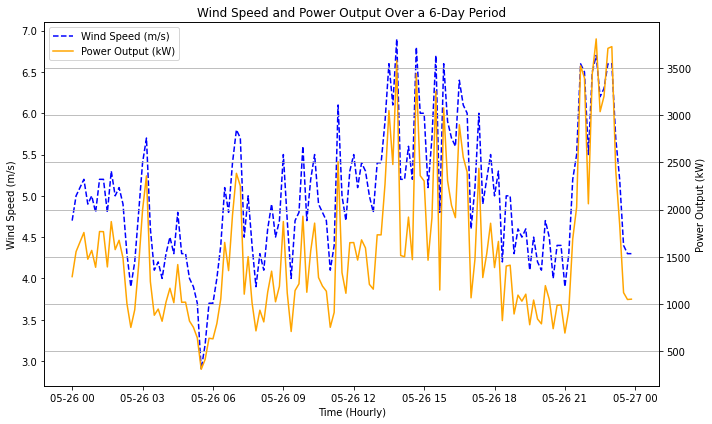

In [ ]:
i = 0
day = 6 * 24

fig, ax1 = plt.subplots(figsize=(10, 6))

line1, = ax1.plot(
    df[params['param_v_wind']][i * day: day * (i + 1)],
    label="Wind Speed (m/s)",
    color="blue",
    linestyle='--'
)
ax1.set_xlabel("Time (Hourly)")
ax1.set_ylabel("Wind Speed (m/s)")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
line2, = ax2.plot(
    power[i * day: day * (i + 1)],
    label="Power Output (kW)",
    color="orange"
)
ax2.set_ylabel("Power Output (kW)")
ax2.tick_params(axis='y')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Wind Speed and Power Output Over a 1-Day Period")
fig.tight_layout()
plt.grid(True)

plt.show()